In [2]:
import numpy as np
import geopandas as gpd
import rasterio
import rioxarray
import matplotlib.pyplot as plt
from rasterio.plot import show
from scipy.stats import linregress
from rasterio.enums import Resampling

### Criando um objeto raster usando numpy e rioxarray
### Equivalentes aos pacotes terra e raster em R

In [3]:
def create_raster(nrows, ncols, xmin, xmax, ymin, ymax, values):
    import xarray as xr
    data = np.reshape(values, (nrows, ncols))
    y = np.linspace(ymin, ymax, nrows)
    x = np.linspace(xmin, xmax, ncols)
    raster = xr.DataArray(data, 
                         coords={'y': y, 'x': x},
                         dims=['y', 'x'])
    raster.rio.write_crs('+proj=utm +zone=20 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs', inplace=True)
    raster.rio.write_transform(rasterio.Affine((xmax - xmin) / ncols, 0, xmin, 
                                              0, -(ymax - ymin) / nrows, ymax), 
                              inplace=True)
    return raster

Gerando valores aleatórios para o raster

In [4]:
values = np.random.uniform(size=36)
raster_t = create_raster(nrows=6, ncols=6, 
                         xmin=-1.5, xmax=1.5, 
                         ymin=-1.5, ymax=1.5, 
                         values=values)

Obtenção de uma imagem de satélite Landsat usando a biblioteca rsi (não disponível diretamente em Python)
Em Python, você pode usar APIs como `earthengine-api` ou `pystac-client` para acessar dados de satélite.
Aqui, vamos simular a obtenção e leitura de uma imagem Landsat com rioxarray.

Simulação da obtenção de dados de satélite (em prática, você usaria uma API específica)
Suponha que temos um arquivo 'manaus_landsat.tif' já baixado.

In [5]:
import ee
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# Autenticar (só precisa fazer uma vez)
ee.Authenticate()

True

In [7]:
# Inicializa o Earth Engine com as credenciais padrão
# Isso usará as credenciais já autenticadas ou solicitará autenticação se necessário
ee.Authenticate()
ee.Initialize(project='earth-simple')

In [8]:

# Define a região de interesse (ROI) - Manaus, Brasil
roi = ee.Geometry.Point(-59.9825, -3.1316).buffer(10000)  # Buffer de 10 km

In [1]:
# Define o intervalo de data
start_date = '2023-09-01'
end_date = '2023-09-30'

In [9]:
# Coletar imagens do Landsat 8 com surface reflectance
landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate(start_date, end_date) \
    .filterBounds(roi) \
    .select(['SR_B4', 'SR_B3', 'SR_B2', 'SR_B5'])  # Red, Green, Blue, NIR

# Pegar a primeira imagem (você também pode usar median para compósitos)
landsat_image = landsat_collection.first()
# Seleciona as bandas desejadas (R, G, B, NIR)
bands = ['SR_B4', 'SR_B3', 'SR_B2', 'SR_B5']

In [43]:

# Baixa a imagem para o Google Drive (atenção: pode ser grande!)
image_path = 'manaus_landsat.tif'
task = ee.batch.Export.image.toDrive(
    image=landsat_image.select(bands),
    description='Manaus_Landsat_Image',
    fileNamePrefix=image_path.replace('.tif', ''),
    fileFormat='GeoTIFF',
    scale=30,  # Resolução espacial de 30 metros
    region=roi.getInfo()['coordinates']
)
task.start()
print(f'Tarefa de download iniciada. O arquivo será salvo no seu Google Drive como: {image_path}')

Tarefa de download iniciada. O arquivo será salvo no seu Google Drive como: manaus_landsat.tif


In [44]:
import time

# Verificar o status da tarefa
while task.active():
    print('Aguardando a conclusão da tarefa...')
    time.sleep(30)  # Espera 30 segundos antes de verificar novamente

print('Tarefa concluída:', task.status())

Aguardando a conclusão da tarefa...
Tarefa concluída: {'state': 'COMPLETED', 'description': 'Manaus_Landsat_Image', 'priority': 100, 'creation_timestamp_ms': 1743358827244, 'update_timestamp_ms': 1743358854987, 'start_timestamp_ms': 1743358836432, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/'], 'attempt': 1, 'batch_eecu_usage_seconds': 0.560846209526062, 'id': '3KM5PPKAM6LGDRFZBPSOG6H4', 'name': 'projects/earth-simple/operations/3KM5PPKAM6LGDRFZBPSOG6H4'}


In [10]:

# Aguarde até que o download esteja completo (isso pode levar algum tempo)
# Verifique o status do task no console do Earth Engine ou via código

image_path = '/home/huguinho/Documents/GitHub/introduction_to_geo_statistics/python_version/manaus_landsat.tif'

# Após o download, carregue a imagem com rasterio
with rasterio.open(image_path) as src:
    landsat_rast = src.read()
    landsat_meta = src.meta


In [ ]:
# Exibe as informações da imagem
print(landsat_meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 665, 'height': 665, 'count': 4, 'crs': CRS.from_epsg(32621), 'transform': Affine(30.0, 0.0, 158505.0,
       0.0, -30.0, -336645.0)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


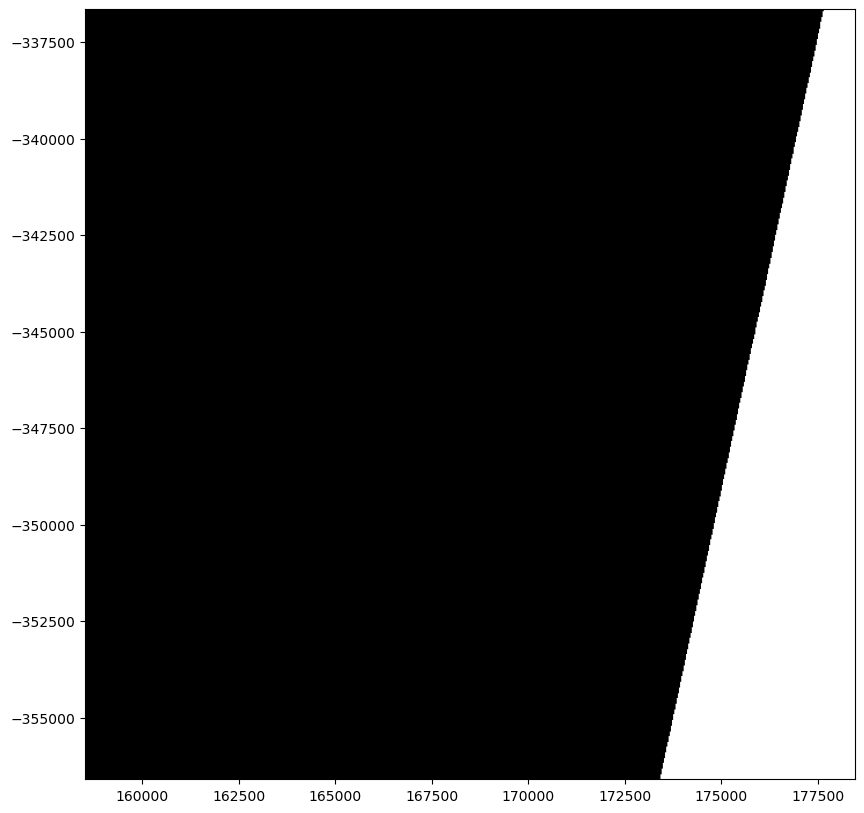

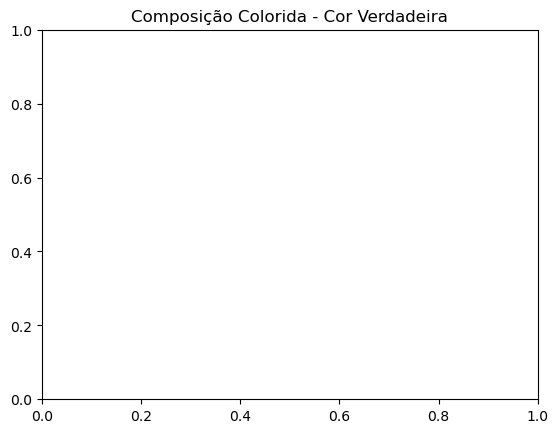

In [ ]:

# Visualização da imagem
plt.figure(figsize=(10, 10))
show(landsat_rast[[2, 1, 0]], transform=landsat_meta['transform'])  # Using bands 3,2,1 for RGB
plt.title('Composição Colorida - Cor Verdadeira')
plt.show()

/tmp/ipykernel_349300/210279292.py:2: RuntimeWarning: invalid value encountered in divide
  ndvi = (landsat_rast[3] - landsat_rast[0]) / (landsat_rast[3] + landsat_rast[0])


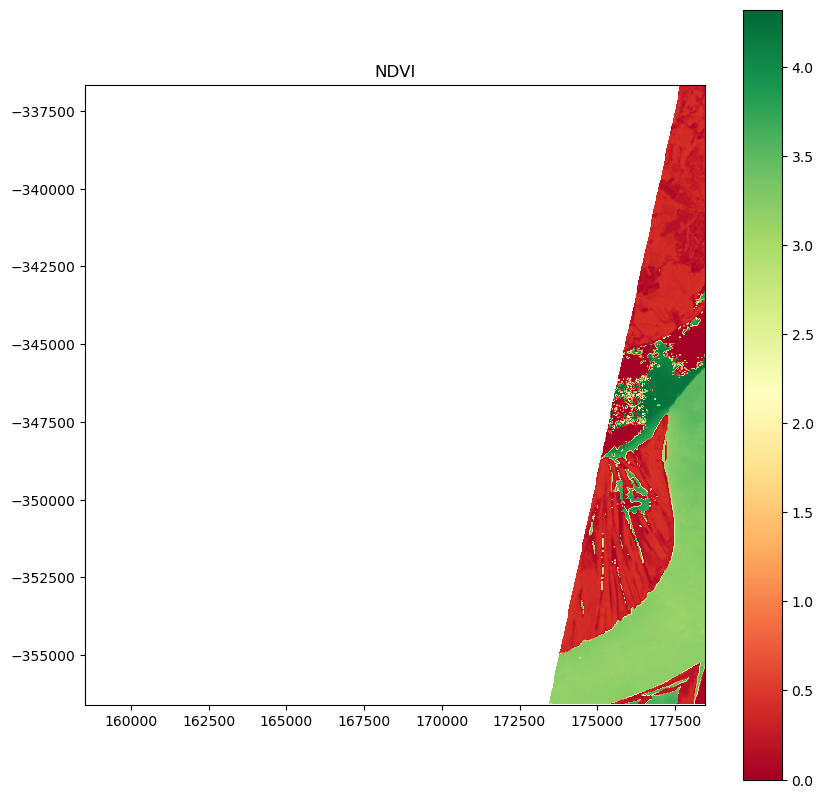

In [17]:

# Calculando NDVI (NIR - Red) / (NIR + Red)
ndvi = (landsat_rast[3] - landsat_rast[0]) / (landsat_rast[3] + landsat_rast[0])

# Calculate bounds from transform
transform = landsat_meta['transform']
width = landsat_meta['width']
height = landsat_meta['height']
bounds = [
	transform[2],                      # left
	transform[2] + width * transform[0], # right
	transform[5] + height * transform[4], # bottom
	transform[5]                       # top
]

plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn', extent=bounds)
plt.colorbar()
plt.title('NDVI')
plt.show()
